In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from peaktk.stats import peakday_helper
from peaktk.dataloader import ISONE_helper
from peaktk.peakhour_prediction import lstm_peakhour
from peaktk.preprocessing import preprocessing, helper

from peaktk.metrics import metrics
from peaktk.peakhour_prediction import lstm_peakhour
from peaktk.peakhour_prediction import lstm_probabilistic



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# load ISO−NE data
DEMAND_PATH = "../data/ISONE/"
WEATHER_PATH = "../data/ISONE/weather"
ISONE_hourly_data = ISONE_helper.load_data_hourly(DEMAND_PATH,WEATHER_PATH)

/Users/phuthipong/miniforge3/envs/mlp/lib/python3.8/site-packages/peaktk/preprocessing/helper.py:200: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = temp_df.append(temp_df.iloc[22], ignore_index=True)
/Users/phuthipong/miniforge3/envs/mlp/lib/python3.8/site-packages/peaktk/preprocessing/helper.py:200: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = temp_df.append(temp_df.iloc[22], ignore_index=True)
/Users/phuthipong/miniforge3/envs/mlp/lib/python3.8/site-packages/peaktk/preprocessing/helper.py:200: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = temp_df.append(temp_df.iloc[22], ignore_index=True)


In [4]:
ISONE_hourly_data.mean()

Load                   13579.659695
temperature               53.088097
humidity                   0.650039
apparentTemperature       50.802523
pressure                1016.541374
windSpeed                  8.054950
cloudCover                 0.557919
windBearing              203.817860
precipIntensity            0.003985
dewPoint                  40.623374
precipProbability          0.089609
dayofweek                  2.994526
dayofyear                183.166971
week                      26.072080
month                      6.521898
hourofday                 11.499886
dtype: float64

In [5]:
# data preprocessing and preparation
ISONE_data_scale, y_scaler = preprocessing.scale(ISONE_hourly_data, min=0 , max=1) 
X_scaled, y_scaled, idx = preprocessing.combine_sameday_week_before_hourly_data2(ISONE_data_scale, "Load")
X_train, X_test, y_train, y_test, idx_train, idx_test= helper.train_test_split(X_scaled, y_scaled, idx, test_size=366)



### LSTM PEAK HOUR MODEL

In [6]:

lstm_model = lstm_peakhour.LSTMPeakHourModel(num_peak_hours=5)
lstm_model.fit(X_train, y_train, epochs=200, verbose=0)
y_hat = lstm_model.predict(X_test)





Metal device set to: Apple M1


2022-10-10 10:48:48.560581: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-10 10:48:48.560682: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-10-10 10:48:49.118559: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-10 10:48:51.392756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-10 10:48:51.741690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-10 10:48:51.836898: I tensorflow/core/grappler/o

 4/12 [=========>....................] - ETA: 0s

2022-10-10 10:50:22.971895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-10 10:50:23.031548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 37ms/step


In [7]:
def find_peak_hour_gt(y_data, num_peak_hours):
    result_list = []
    for y in y_data:
        idx = np.argpartition(y, -num_peak_hours)[-num_peak_hours:]
        result = np.array([False]*24)
        result[idx] = True
        result_list.append(result)
    return np.array(result_list)
    

In [8]:
y_true_ph = find_peak_hour_gt(y_test, 5)
ph_results = metrics.peak_hour_accuracy(y_true_ph, y_hat)
ph_results

(0.8021857923497266, 0.8021857923497266, 0.8750647109577222)

### LSTM PROBABILISTIC MODEL

In [9]:
# binary for train
y_train_bin = find_peak_hour_gt(y_train, 5)

In [10]:
# train LSTM Prob model - can tune hyperparameters
lstm_prob = lstm_probabilistic.LSTMProbabilistic(num_peak_hours=5)
lstm_prob.fit(X_train, y_train_bin, epochs=200, verbose=0)
y_hat = lstm_prob.predict(X_test)


2022-10-10 10:50:27.723381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-10 10:50:28.236427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-10 10:50:28.360281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-10 10:50:28.439063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-10 10:50:28.505891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-10 10:50:28.571535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-10 10:50:28.634166: I tensorflow/core/grappler/optimizers/cust

 1/12 [=>............................] - ETA: 14s

2022-10-10 10:52:39.167836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-10 10:52:39.240036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-10 10:52:39.297214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 2s 54ms/step


/Users/phuthipong/miniforge3/envs/mlp/lib/python3.8/site-packages/peaktk/peakhour_prediction/lstm_probabilistic.py:157: RuntimeWarning: invalid value encountered in sqrt
  return 0.1 * np.sqrt(np.array(y_hat) * 100)


<h3> Demand and Peak Forecasting Plot </h3>

In [11]:
def plot_fig(y_true, y_pred, peak_pred):
    # plot result
    show_len = len(y_true)
    
    fig, ax1 = plt.subplots()
    ax1.plot(np.arange(show_len), y_true[:show_len], label="Actual", color="#1982c4")
    ax1.plot(np.arange(show_len), y_pred[:show_len], label="Forecast", color="#f95738")
    
    ax2 = ax1.twinx()
    ax2.plot(np.arange(show_len), peak_pred[:show_len], '--', label="isPeak", color="#20bf55")
    ax2.set_yticks([0,1,2,3])
    ax2.set_yticklabels(["False","True","",""])
    ax2.set_ylim([-0.3, 4])
    
    plt.xlabel('Hours of day')
    ax1.set_ylabel('Demand (MWh)') 
    xi = list(range(0, 25, 4))
    plt.xticks(xi, xi)
    
    fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
    plt.show()
    

In [12]:
inv_test_y = y_scaler.inverse_transform(y_test)
inv_test_y_flatten = inv_test_y.flatten()

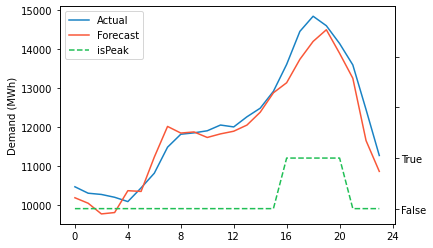

In [13]:
plot_fig(inv_test_y[167], y_scaler.inverse_transform(lstm_model.pred_demand)[167], y_true_ph[167])

### Battery Dispatch Plot - One week

In [14]:
def find_duck(d, num_peak_hours):
    idx = np.argpartition(d, num_peak_hours)[:num_peak_hours]
    result = np.array([False]*24)
    result[idx] = True
    return result

In [15]:
battery_max_charge = 400
new_demand = []
pred_demand = y_scaler.inverse_transform(lstm_model.pred_demand)
for i in range(y_true_ph.shape[0]):
    daily_d = pred_demand[i].copy()
    y_duck = find_duck(daily_d, 5)
    for j in range(24):
        if y_true_ph[i][j]:
            daily_d[j] -= battery_max_charge
    for j in range(24):
        if y_duck[j]:
            daily_d[j] += battery_max_charge
        
    new_demand.append(daily_d)
    

In [16]:
def plot_battery_dispatch(y_true, y_pred):
    # plot result
    show_len = len(y_true)
    
    fig, ax1 = plt.subplots()
    ax1.plot(np.arange(show_len), y_true[:show_len], label="Original Demand", color="#247ba0")    
    ax1.plot(np.arange(show_len), y_pred[:show_len], label="After Battery Dispatch", color="#f95738")
    ax1.fill_between(np.arange(show_len), y_true[:show_len], y_pred[:show_len], alpha=0.2)
    
    plt.xlabel('Days')
    ax1.set_ylabel('Demand (MWh)') 
    
    xi = list(range(0, 24*7+1, 24))
    
    x = list(range(0, 7+1, 1))
    plt.xticks(xi, x)
    
    fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
    plt.show()
    

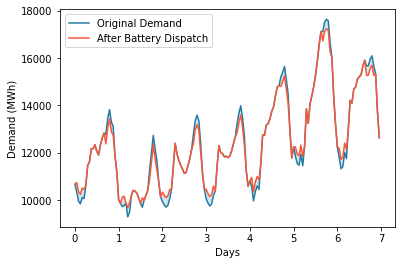

In [17]:
plot_battery_dispatch(pred_demand[150:157].flatten(), np.array(new_demand)[150:157].flatten())